In [1]:
import os
import numpy as np
import cv2
from scipy.stats import qmc

from src.foveation import (
	generate_gabor_enhanced_foveated_image, 
	display_foveated_results, 
	generate_blue_noise_enhanced_image,
)

from src.bluenoise import blue_noise_field_from_poisson_points

from src.pyramids import make_gaussian_pyramid, make_laplacian_pyramid
from src.utils import load_image, display_image

### Load a test image and display the Gaussian and Laplacian Pyramids

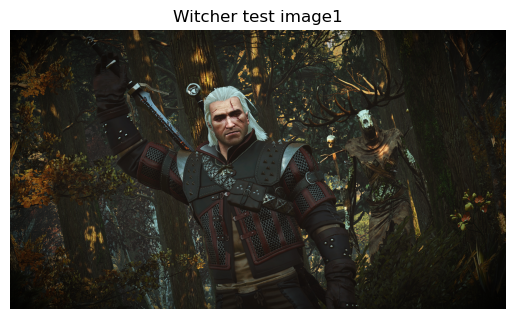

In [2]:
test_image = load_image("input_images/witcher/1.jpeg")
display_image(test_image, "Witcher test image1")

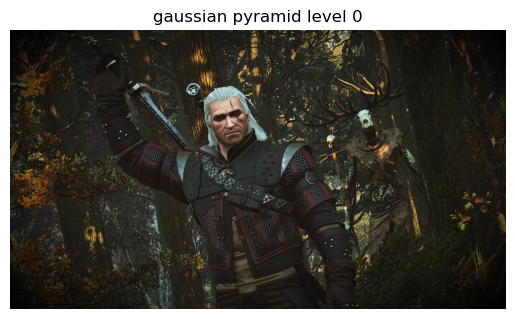

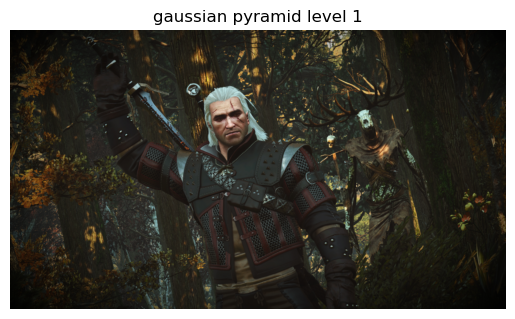

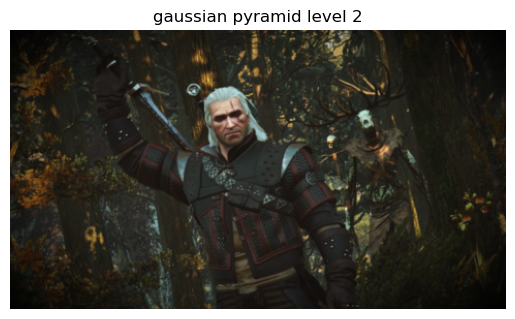

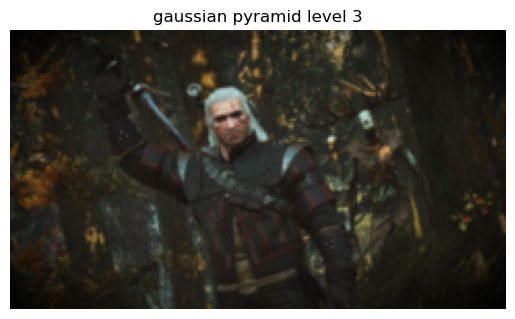

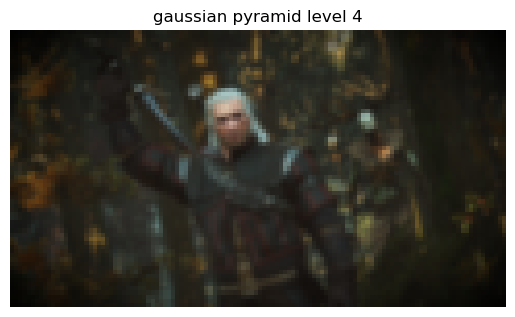

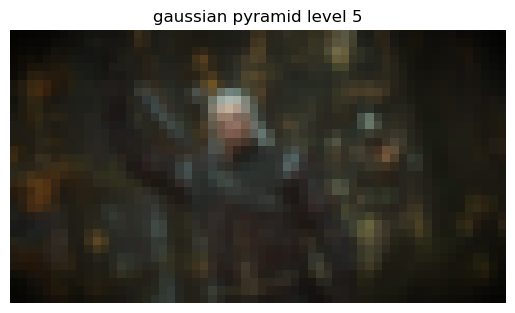

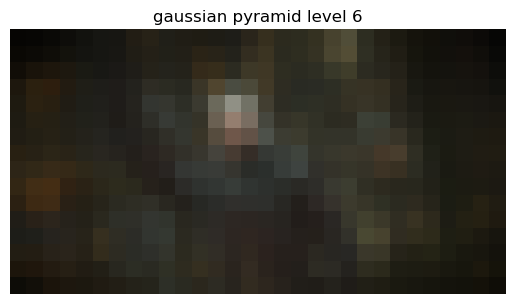

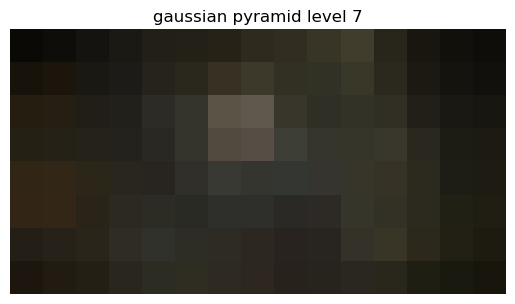

In [3]:
test_image_gaussian_pyramids = make_gaussian_pyramid(test_image, 8)

for i in range(0, len(test_image_gaussian_pyramids)):
	display_image(test_image_gaussian_pyramids[i], f"gaussian pyramid level {i}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6766582..0.74130285].


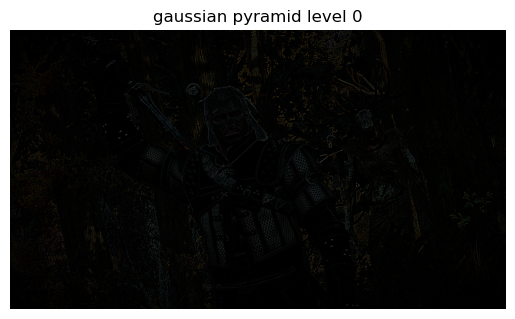

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38170695..0.5087217].


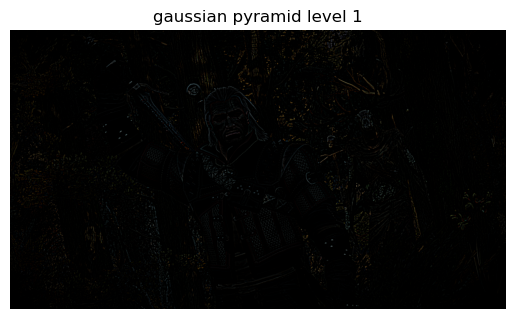

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26820982..0.36834702].


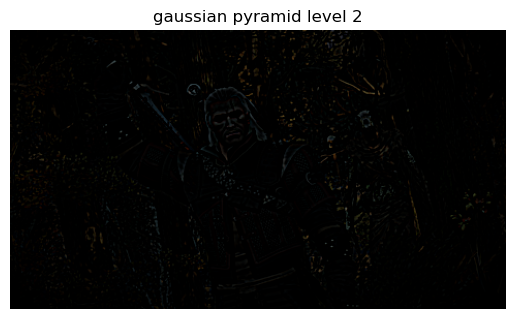

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26636302..0.36180586].


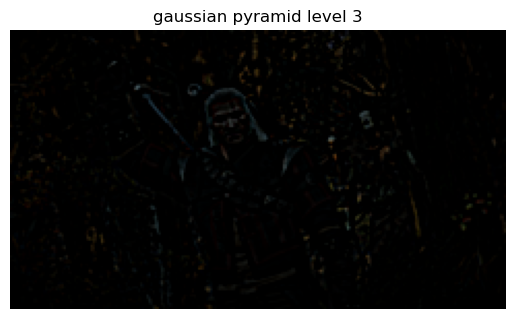

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25751883..0.29609618].


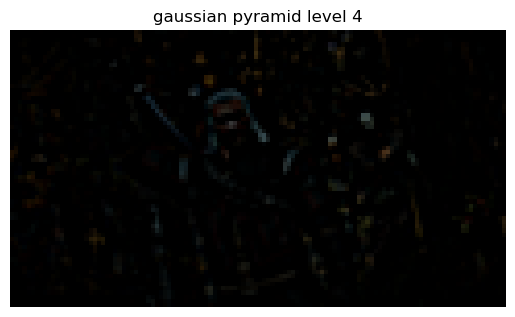

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11555192..0.23614475].


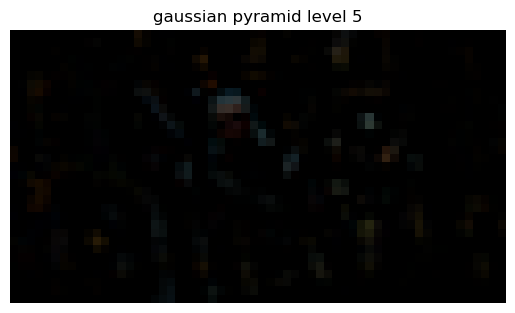

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07584338..0.25540885].


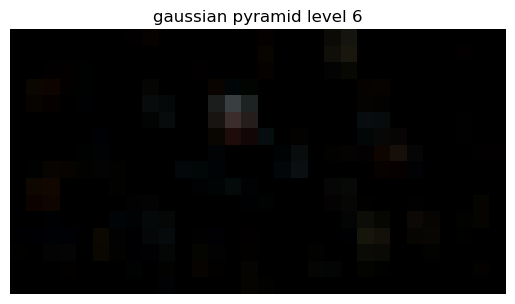

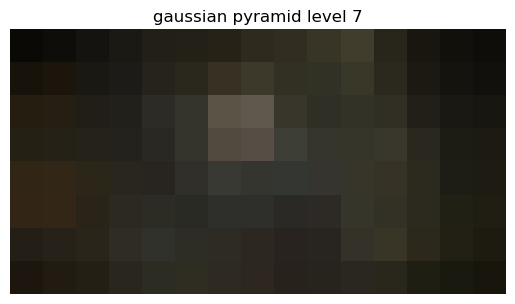

In [4]:
test_image_laplacian_pyramids = make_laplacian_pyramid(test_image, 8, test_image_gaussian_pyramids)

for i in range(0, len(test_image_laplacian_pyramids)):
	display_image(test_image_laplacian_pyramids[i], f"gaussian pyramid level {i}")

In [5]:
(final_enhanced_image, foveated_image, sigma_map) = generate_gabor_enhanced_foveated_image(
	path = "input_images/witcher/3.jpeg",
	levels = 5,
	gaze_xy = (1920 / 2, 1080 / 2),
	dpi = 110,
	viewing_distance_m = 0.71,
	blur_rate_arcmin_per_degree = 0.34,
	fe = 0.2,
	s_k = 20,
	cells = 32,
	impulses_per_cell = 32, # test 32, 64
	seed = 10)


# This is buggy...
#display_foveated_results(final_enhanced_image, foveated_image, sigma_map)


cv2.imwrite("final_enhanced.png", (np.clip(final_enhanced_image, 0, 1) * 255).astype(np.uint8))
cv2.imwrite("foveated.png",       (np.clip(foveated_image,       0, 1) * 255).astype(np.uint8))
cv2.imwrite("sigma_map.png",      (np.clip(sigma_map / (sigma_map.max() + 1e-8), 0, 1) * 255).astype(np.uint8))








True

In [8]:
(final_enhanced_image, foveated_image, sigma_map, bluenoise, bluenoise_notscaled, blue_amp) = generate_blue_noise_enhanced_image(
	path = "input_images/witcher/3.jpeg",
	num_levels = 5,
	gaze_xy = (1920 / 2, 1080 / 2),
	dpi = 110.0,
	viewing_distance_m = 0.71,
	blur_rate_arcmin_per_degree = 0.34,
	fe = 0.2,
	s_k = 20,
	r_px = 7,
	sigma_blob = 3.0,
	seed = 0)

testfield = blue_noise_field_from_poisson_points(1920, 1080, r_px = 9, seed = 3, sigma_blob = 3)
cv2.imwrite("bluenoise_field.png", (np.clip(testfield, 0, 1) * 255).astype(np.uint8))


cv2.imwrite("blue_final_enhanced.png", (np.clip(final_enhanced_image, 0, 1) * 255).astype(np.uint8))
cv2.imwrite("blue_foveated.png",       (np.clip(foveated_image,       0, 1) * 255).astype(np.uint8))
cv2.imwrite("blue_scaled.png",      (np.clip(bluenoise, 0, 1) * 255).astype(np.uint8))
cv2.imwrite("blue_not_scaled.png",      (np.clip(bluenoise_notscaled, 0, 1) * 255).astype(np.uint8))
cv2.imwrite("blue_amp.png",      (np.clip(blue_amp, 0, 1) * 255).astype(np.uint8))

diff = np.abs(final_enhanced_image - foveated_image)
cv2.imwrite("blue_diff_enhanced_vs_foveated.png", (np.clip(diff * 255.0, 0, 255)))


True

In [7]:
from src.foveation import foveate_image, radial_sigma_map
from src.utils import pixels_per_degree

# -*- coding: utf-8 -*-
# Blue-noise detail reconstruction for foveated images (ds-wave inspired)
# References: Öztireli 2020 anti-aliasing sampling theory and variational spectra (CGF'20).

import numpy as np

try:
	import cv2
	_HAS_CV2 = True
except:
	_HAS_CV2 = False

# ---------------------------
# Basic helpers (tabs only!)
# ---------------------------

def _int_to_float(x: np.ndarray) -> np.ndarray:
	if x.dtype == np.uint8:
		return x.astype(np.float32) / 255.0
	return x.astype(np.float32)

def _to_uint8(x: np.ndarray) -> np.ndarray:
	x = np.clip(x, 0.0, 1.0)
	return (x * 255.0 + 0.5).astype(np.uint8)

def _gaussian_blur(img: np.ndarray, sigma: float) -> np.ndarray:
	if sigma <= 0.0:
		return img
	if _HAS_CV2:
		ks = int(max(3, 2 * int(3 * sigma) + 1))
		return cv2.GaussianBlur(img, (ks, ks), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT)
	# Fallback: separable FFT Gaussian
	h, w = img.shape[:2]
	y = np.fft.fftfreq(h).reshape(-1,1)
	x = np.fft.fftfreq(w).reshape(1,-1)
	g = np.exp(-2.0 * (np.pi**2) * sigma**2 * (x**2 + y**2)).astype(np.float32)
	if img.ndim == 2:
		F = np.fft.fft2(img)
		return np.fft.ifft2(F * g).real.astype(np.float32)
	else:
		out = np.zeros_like(img, dtype=np.float32)
		for c in range(img.shape[2]):
			F = np.fft.fft2(img[:,:,c])
			out[:,:,c] = np.fft.ifft2(F * g).real
		return out

def pyramid_downscale(img: np.ndarray) -> np.ndarray:
	# pyrDown equivalent (anti-aliased)
	if _HAS_CV2:
		return cv2.pyrDown(img)
	# fallback: Gaussian + 2x decimation
	blur = _gaussian_blur(img, sigma=1.0)
	return blur[::2, ::2] if img.ndim == 2 else blur[::2, ::2, :]

def pyramid_upscale(img: np.ndarray, target_shape) -> np.ndarray:
	# pyrUp equivalent
	if _HAS_CV2:
		return cv2.resize(img, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)
	# fallback: bilinear via np.kron
	scale_y = target_shape[0] / img.shape[0]
	scale_x = target_shape[1] / img.shape[1]
	if abs(scale_x - 2.0) < 1e-3 and abs(scale_y - 2.0) < 1e-3:
		# simple nearest + blur to approximate bilinear
		ups = np.repeat(np.repeat(img, 2, axis=0), 2, axis=1)
		return _gaussian_blur(ups, sigma=0.8)
	# generic
	ys = np.linspace(0, img.shape[0]-1, target_shape[0], dtype=np.float32)
	xs = np.linspace(0, img.shape[1]-1, target_shape[1], dtype=np.float32)
	xg, yg = np.meshgrid(xs, ys)
	x0 = np.floor(xg).astype(np.int32).clip(0, img.shape[1]-2)
	y0 = np.floor(yg).astype(np.int32).clip(0, img.shape[0]-2)
	wx = (xg - x0).astype(np.float32)
	wy = (yg - y0).astype(np.float32)
	def samp(ch):
		I00 = img[y0, x0, ch] if img.ndim == 3 else img[y0, x0]
		I10 = img[y0, x0+1, ch] if img.ndim == 3 else img[y0, x0+1]
		I01 = img[y0+1, x0, ch] if img.ndim == 3 else img[y0+1, x0]
		I11 = img[y0+1, x0+1, ch] if img.ndim == 3 else img[y0+1, x0+1]
		return (1-wy)*((1-wx)*I00 + wx*I10) + wy*((1-wx)*I01 + wx*I11)
	if img.ndim == 2:
		return samp(None).astype(np.float32)
	out = np.zeros((target_shape[0], target_shape[1], img.shape[2]), dtype=np.float32)
	for c in range(img.shape[2]):
		out[:,:,c] = samp(c)
	return out

def make_gaussian_pyramid(image: np.ndarray, level: int) -> list:
	if level < 1:
		raise ValueError("Level must be >= 1 (lvl 0 is the base mip)")
	pyramid = [None] * level
	pyramid[0] = _int_to_float(image)
	for i in range(1, level):
		pyramid[i] = pyramid_downscale(pyramid[i - 1])
	return pyramid

def make_laplacian_pyramid(image: np.ndarray, level: int, gaussian_pyramid=None) -> list:
	if gaussian_pyramid is None:
		gaussian_pyramid = make_gaussian_pyramid(image, level)
	laplacian_pyramid = [None] * level
	for i in range(0, level - 1):
		upscaled = pyramid_upscale(gaussian_pyramid[i + 1], gaussian_pyramid[i].shape)
		laplacian_pyramid[i] = gaussian_pyramid[i] - upscaled
	laplacian_pyramid[-1] = gaussian_pyramid[-1].copy()
	return laplacian_pyramid

def collapse_laplacian_pyramid(lap_pyr: list) -> np.ndarray:
	L = lap_pyr[-1]
	for i in range(len(lap_pyr)-2, -1, -1):
		L = pyramid_upscale(L, lap_pyr[i].shape) + lap_pyr[i]
	return L

# ----------------------------------------------
# Frequency helpers: radial grids & ds-wave P(ν)
# ----------------------------------------------

def _freq_r_grid(h: int, w: int) -> np.ndarray:
	# normalized radial frequency r in [0,1], where 1 ~ axis Nyquist
	fy = np.fft.fftfreq(h).reshape(-1,1)  # cycles per pixel, in [-0.5,0.5)
	fx = np.fft.fftfreq(w).reshape(1,-1)
	r = np.sqrt(fx*fx + fy*fy) / 0.5  # normalize so Nyquist on axis -> r=1
	return r.astype(np.float32)

def ds_wave_power_spectrum(shape, nu0=0.8, e0=0.0, m0=1.6, band_width=0.12, decay=0.55, undershoot=0.15):
	"""
	Construct a ds-wave-inspired radial power spectrum P(r):
	- P(r) = e0 for r < nu0 (hard low-frequency bound, Eq. 14)
	- For r >= nu0, add decaying square-wave plateaus to limit local maxima (Eq. 16 intuition).
	- Clamp maxima at m0 (Eq. 17).
	"""
	h, w = shape[:2]
	r = _freq_r_grid(h, w)
	P = np.ones((h, w), dtype=np.float32)

	# Low freq region
	P[r < nu0] = e0

	# High freq region: decaying square-wave plateaus
	if band_width <= 0:
		return np.clip(P, 0.0, m0)

	r_hi = np.maximum(0.0, r - nu0)
	k = np.floor(r_hi / band_width).astype(np.int32)
	# alternating plateaus: even k -> +A_k, odd k -> slight undershoot (keeps TV small & flatter E(ν))
	A0 = max(0.0, m0 - 1.0)  # initial headroom above 1
	Ak = (A0 * (decay ** np.clip(k, 0, 1000))).astype(np.float32)
	even = ((k % 2) == 0)
	odd = ~even

	P_hi = np.ones_like(P)
	P_hi[even] = 1.0 + Ak[even]
	P_hi[odd]  = np.maximum(e0, 1.0 - undershoot * Ak[odd])  # keep non-negative

	P = np.where(r >= nu0, P_hi, P)
	return np.clip(P, 0.0, m0).astype(np.float32)

def synthesize_noise_with_power(shape, P, seed=None):
	if seed is not None:
		np.random.seed(seed)
	noise = np.random.randn(*shape[:2]).astype(np.float32)
	F = np.fft.fft2(noise)
	# Use sqrt(P) as magnitude shaping filter
	H = np.sqrt(np.maximum(P, 0.0)).astype(np.float32)
	G = F * H
	n = np.fft.ifft2(G).real.astype(np.float32)
	# zero-mean, unit-variance normalize
	n -= n.mean()
	std = n.std() + 1e-8
	n /= std
	return n

# ----------------------------------------------
# Eccentricity & bandwise weighting (foveated)
# ----------------------------------------------

def make_eccentricity_map(shape, center=None):
	h, w = shape[:2]
	if center is None:
		cy, cx = h / 2.0, w / 2.0
	else:
		cy, cx = float(center[1]), float(center[0])  # (x, y) -> (cy, cx)
	y = np.arange(h, dtype=np.float32).reshape(-1,1)
	x = np.arange(w, dtype=np.float32).reshape(1,-1)
	r = np.sqrt((x - cx)**2 + (y - cy)**2)
	r /= np.sqrt((max(cx, w-cx))**2 + (max(cy, h-cy))**2) + 1e-8  # normalize to [0,1]
	return np.clip(r, 0.0, 1.0)

def local_detail_loss_map(img_gray: np.ndarray, win=7):
	# lower output where strong detail remains; higher where foveation smoothed things
	# Use local variance of a high-pass (Laplacian) as proxy; invert & normalize.
	if _HAS_CV2:
		lap = cv2.Laplacian(img_gray, cv2.CV_32F, ksize=3)
		var = cv2.GaussianBlur(lap*lap, (win|1, win|1), 0)
	else:
		# simple 3x3 Laplacian kernel
		k = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32)
		lap = _conv2(img_gray, k)
		var = _gaussian_blur(lap*lap, sigma=max(1.0, (win-1)/6.0))
	# Invert & stretch
	var = var.astype(np.float32)
	vmax = np.percentile(var, 95.0) + 1e-8
	score = 1.0 - np.clip(var / vmax, 0.0, 1.0)  # high when detail low
	# smooth
	if _HAS_CV2:
		score = cv2.GaussianBlur(score, (0,0), 1.0)
	else:
		score = _gaussian_blur(score, 1.0)
	return np.clip(score, 0.0, 1.0).astype(np.float32)

def _conv2(img, k):
	# tiny helper if cv2 is absent
	F = np.fft.fft2(img)
	K = np.fft.fft2(np.pad(k, (((img.shape[0]-k.shape[0]),0), ((img.shape[1]-k.shape[1]),0))), s=img.shape)
	return np.fft.ifft2(F * K).real.astype(np.float32)

# ----------------------------------------------
# Main API
# ----------------------------------------------


def reconstruct_blue_noise_details(
	foveated_image: np.ndarray,
	levels: int = 5,
	center_xy: tuple = None,
	global_amount: float = 0.6,
	nu0: float = 0.8,
	e0: float = 0.0,
	m0: float = 1.6,
	band_width: float = 0.12,
	decay: float = 0.55,
	undershoot: float = 0.15,
	seed: int = 42,
	per_level_amount: list = None
):
	"""
	Inject ds-wave-shaped blue noise into high-frequency bands of a foveated image.
	Returns float32 in [0,1].
	"""
	img = _int_to_float(foveated_image)
	is_color = (img.ndim == 3 and img.shape[2] == 3)
	img_gray = (0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]).astype(np.float32) if is_color else img

	# Build pyramids
	G = make_gaussian_pyramid(img, levels)
	L = make_laplacian_pyramid(img, levels, gaussian_pyramid=G)

	# Base weight maps at full resolution
	ecc0 = make_eccentricity_map(img_gray.shape, center=center_xy)  # [0..1], 0=fovea
	ecc_weight_full = np.clip((ecc0**0.9), 0.0, 1.0).astype(np.float32)
	loss_weight_full = local_detail_loss_map(img_gray)
	base_weight_full = np.clip(0.35 * ecc_weight_full + 0.65 * loss_weight_full, 0.0, 1.0).astype(np.float32)

	# Build weight pyramids to match Laplacian band shapes
	ecc_weight_pyr = make_gaussian_pyramid(ecc_weight_full, levels)
	base_weight_pyr = make_gaussian_pyramid(base_weight_full, levels)

	if per_level_amount is None:
		per_level_amount = np.linspace(1.0, 0.3, levels).astype(np.float32)

	out_L = []
	rng = np.random.RandomState(seed)

	for lvl in range(levels):
		band = L[lvl]
		sh = band.shape[:2] if band.ndim == 3 else band.shape

		# Per-level weight map at correct resolution
		ecc_w = ecc_weight_pyr[lvl]
		base_w = base_weight_pyr[lvl]
		if lvl > 0:
			# At coarser levels, slightly reduce reliance on loss map
			bleed = 0.25 * (lvl / max(1, levels-1))
			w_local = np.clip((1.0 - bleed) * base_w + bleed * ecc_w, 0.0, 1.0)
		else:
			w_local = base_w

		# Create ds-wave spectrum & synthesize noise at this resolution
		P = ds_wave_power_spectrum(sh, nu0=nu0, e0=e0, m0=m0, band_width=band_width, decay=decay, undershoot=undershoot)
		n = synthesize_noise_with_power(sh, P, seed=rng.randint(0, 2**31-1))

		amp = global_amount * per_level_amount[lvl]

		# Normalize band energy and add noise, per channel
		if band.ndim == 2:
			std_b = np.median(np.abs(band)) * 1.4826 + 1e-6
			alpha = amp * (std_b / 1.0)  # noise already unit variance
			out_L.append(band + (alpha * w_local) * n)
		else:
			out = np.zeros_like(band, dtype=np.float32)
			for c in range(band.shape[2]):
				std_b = np.median(np.abs(band[:,:,c])) * 1.4826 + 1e-6
				alpha = amp * (std_b / 1.0)
				out[:,:,c] = band[:,:,c] + (alpha * w_local) * n
			out_L.append(out)

	# Reconstruct
	recon = collapse_laplacian_pyramid(out_L)
	return np.clip(recon, 0.0, 1.0).astype(np.float32)



# ----------------------------------------------
# Convenience wrapper: run end-to-end
# ----------------------------------------------

def blue_noise_refill_foveated(
	foveated_image: np.ndarray,
	levels: int = 5,
	center_xy: tuple = None,
	strength: float = 0.6
) -> np.ndarray:
	"""
	Simple one-call entry point with sensible defaults.
	"""
	return reconstruct_blue_noise_details(
		foveated_image,
		levels=levels,
		center_xy=center_xy,
		global_amount=strength,
		nu0=0.8,		# big clean low-frequency region
		e0=0.0,		# zero energy at low f if you want it extra clean; set ~0.05-0.1 to flatten peaks further
		m0=1.6,		# cap maxima to reduce colored noise
		band_width=0.12,
		decay=0.55,
		undershoot=0.15,
		seed=42)

# Example (commented):
# img_fov = ... # np.ndarray, HxW or HxWx3 in [0,1] or uint8
# recon = blue_noise_refill_foveated(img_fov, levels=5, center_xy=(img_fov.shape[1]//2, img_fov.shape[0]//2), strength=0.65)
# show/save: _to_uint8(recon)

test_image = load_image("input_images/witcher/3.jpeg", grayscale=False, as_float=True)   # BGR in [0,1]
H, W = test_image.shape[:2]
ppd = pixels_per_degree(110, 0.71)
sigma_map = radial_sigma_map(H, W, (H // 2, W // 2), ppd, 0.34)

foveated_image = foveate_image(test_image, sigma_map)
reconstructed = blue_noise_refill_foveated(foveated_image, levels=5, center_xy=(foveated_image.shape[1]//2, foveated_image.shape[0]//2), strength=0.65)


cv2.imwrite("test_bluenoise_paperstuff.png", (np.clip(reconstructed * 255.0, 0, 255)))


True